## LRP

In [32]:
# Biblioteki

from PIL import Image
import torchvision.transforms as transforms
import torch

from zennit.rules import Epsilon
from zennit.composites import EpsilonPlusFlat, EpsilonAlpha2Beta1Flat, DeconvNet, GuidedBackprop, BetaSmooth, ExcitationBackprop
from zennit.attribution import Gradient

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from dataclasses import dataclass
from typing import Callable
from scipy.stats import pearsonr

from util.facenet_model import model
from zennit.image import imgify, imsave


INPUT_IMG_FILE = "input.png"
RELEVANCE_IMG_FILE = "relevance.png"


### Załadowanie modelu


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load("facenet_classifier.pth", map_location=torch.device("cpu")))
model.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [34]:
### Data util

from torchvision import transforms
from PIL import Image
import os
import re

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

def prepare_image(device, image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image


def get_image_for_classes(dir, classes):
    class_files = {}
    for c in classes:
        class_files[c] = []

    for fname in sorted(os.listdir(dir)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            match = re.search(r'@([^@]+)@', fname)
            if match:
                label = match.group(1)
                if label in classes:
                    class_files[label].append(os.path.join(dir, fname))
    return class_files

# classes we trained the model for:
face_classes = ['N08_identity_4',
 'N00_identity_14',
 'N00_identity_11',
 'N00_identity_0',
 'N04_identity_5']

CLASSES_FILES = get_image_for_classes('data/', face_classes)



### LRP

In [35]:
# Metoda LRP
def LRP_method(pytorch_model, input_image, composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)): #EpsilonPlusFlat(epsilon=1e-6)

    pytorch_model.eval()

    with Gradient(pytorch_model, composite=composite) as attributor:
        output, relevance = attributor(input_image)

    return output,  relevance

def plot_lrp(input_image, relevance):
    for _, inp in enumerate(input_image):
        imsave(INPUT_IMG_FILE, inp.detach())

    absrel = relevance.abs().sum(1)
    imsave(RELEVANCE_IMG_FILE, absrel[0], vmin=0, vmax=absrel[0].amax())
    image = imgify(absrel[0], vmin=0, vmax=absrel[0].amax())

    image1 = mpimg.imread(INPUT_IMG_FILE)
    image2 = mpimg.imread(RELEVANCE_IMG_FILE)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title("Original Image")

    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title("LRP Heatmap")

    plt.tight_layout()
    plt.show()

    os.remove(INPUT_IMG_FILE)
    os.remove(RELEVANCE_IMG_FILE)



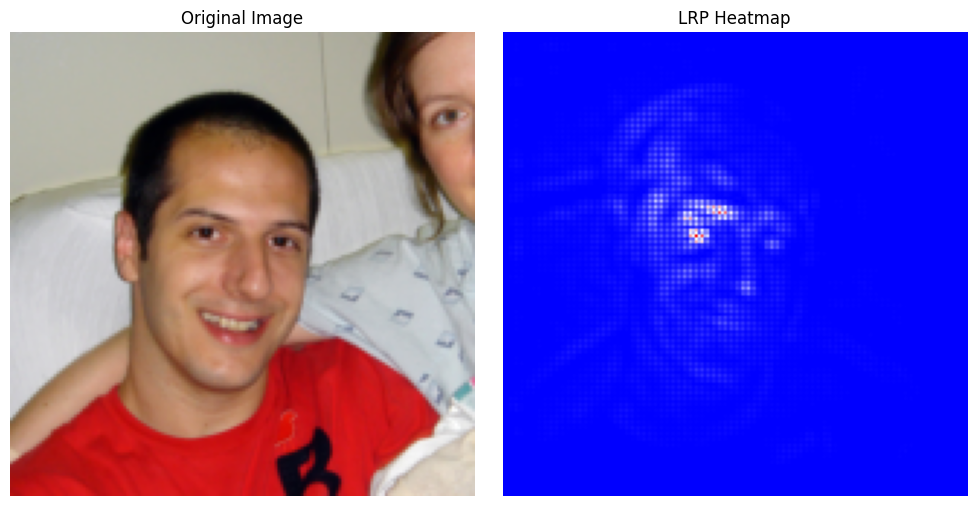

In [36]:
image_path = CLASSES_FILES[face_classes[0]][3]
input_image = prepare_image(device, image_path)

output, relevance = LRP_method(model, input_image, composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)) #composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)

plot_lrp(input_image, relevance)

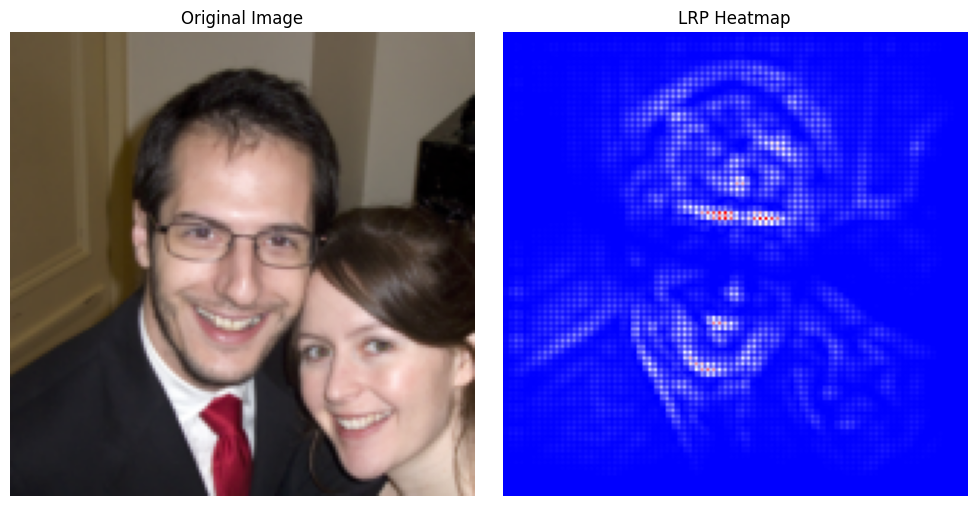

In [37]:
image_path = CLASSES_FILES[face_classes[0]][8]
input_image = prepare_image(device, image_path)

output, relevance = LRP_method(model, input_image, composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)) #composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)

plot_lrp(input_image, relevance)

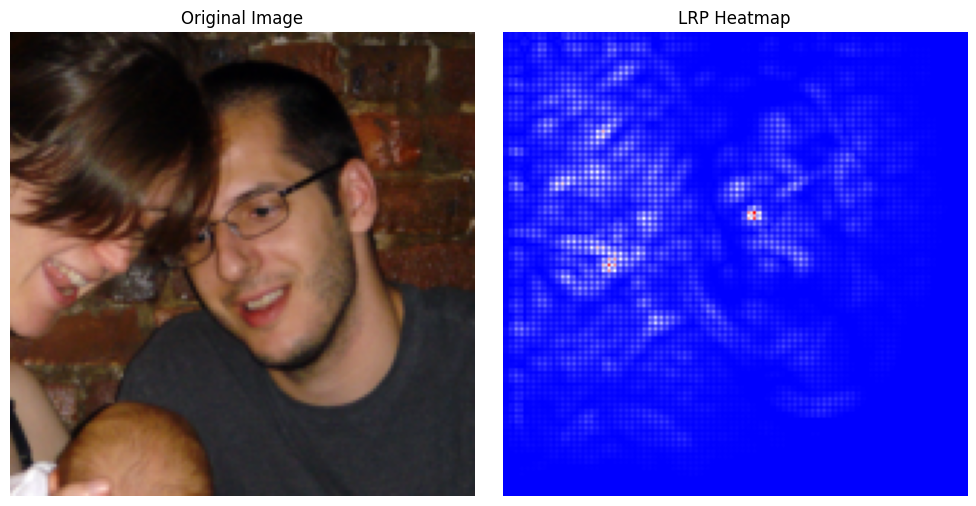

In [45]:
image_path = CLASSES_FILES[face_classes[0]][7]
input_image = prepare_image(device, image_path)

output, relevance = LRP_method(model, input_image, composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)) #composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)

plot_lrp(input_image, relevance)

### Metrics

In [39]:
# Metrics utils

DAUC = "DAUC"
IAUC = "IAUC"
DELETION = "Deletion"
INSERTION = "Insertion"

@dataclass
class CorrMetricsParams:
    perturbed_image: Callable
    mask: Callable
    label: str


def cloned_image(input_image):
    return input_image.clone()

def zeros_image(input_image):
    return torch.zeros_like(input_image)

def mask_set_zero(abs_relevance, num_remove, sorted_indices):
    mask = torch.ones_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_remove]] = 0  # Set most relevant pixels to 0
    return mask

def mask_set_one(abs_relevance, num_add, sorted_indices):
    mask = torch.zeros_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_add]] = 1  # Set most relevant pixels to 1
    return mask

del_corr = CorrMetricsParams(
    perturbed_image=cloned_image,
    mask=mask_set_zero,
    label="removed"
)

ins_corr = CorrMetricsParams(
    perturbed_image=zeros_image,
    mask=mask_set_one,
    label="added"
)

metrics_params = {
    DAUC: True,
    IAUC: False,
    DELETION: del_corr,
    INSERTION: ins_corr,
}

def apply_mask(input_image, mask, abs_relevance):
    mask = mask.view(abs_relevance.shape).unsqueeze(0).repeat(3, 1, 1)
    perturbed_image = input_image * mask
    return perturbed_image

def get_abs_relevance(relevance):
    return relevance.abs().sum(1)[0]

def get_num_pixels(input_image):
    return input_image.shape[2] * input_image.shape[3]


In [50]:

def compute_auc(model, input_image, output, relevance, auc, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=metrics_params[auc])

    perturbed_image = cloned_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        perturbation_curve.append(output.argmax(1).item())

    x_vals = np.linspace(0, 1, steps)
    auc_value = np.trapz(perturbation_curve, x_vals)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel("Fraction of pixels occluded")
        plt.ylabel("Model Output Score")
        plt.title(f"{auc} Evaluation (AUC = {auc_value:.4f})")
        plt.legend()
        plt.show()

    return auc_value, perturbation_curve

def compute_ins_del_correlation(model, input_image, output, relevance, corr, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = metrics_params[corr].perturbed_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)

        mask = metrics_params[corr].mask(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        perturbation_curve.append(output.argmax(1).item())

    x_vals = np.linspace(0, 1, steps)
    correlation, _ = pearsonr(x_vals, perturbation_curve)  # Pearson

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel(f"Fraction of pixels {metrics_params[corr].label}")
        plt.ylabel("Model Output Score")
        plt.title(f"{corr} Correlation = {correlation:.4f}")
        plt.legend()
        plt.show()

    return correlation

def compute_average_drop(model, input_image,output, relevance, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = cloned_image(input_image)
    drop_curve = []
    initial_output = model(input_image).argmax(1).item()
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)

        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        drop = initial_output - output.argmax(1).item()
        drop_curve.append(drop)

    average_drop = np.mean(drop_curve)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), drop_curve, marker='o', label="Output Drop")
        plt.xlabel("Fraction of pixels removed")
        plt.ylabel("Drop in model output")
        plt.title(f"Average Drop = {average_drop:.4f}")
        plt.legend()
        plt.show()

    return average_drop

def compute_increase_in_confidence(model, input_image, output, relevance, steps=10, plot=False):

    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = zeros_image(input_image)
    confidence_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_add = int((step / steps) * num_pixels)

        mask = mask_set_one(abs_relevance, num_add, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        confidence = torch.sigmoid(output.argmax(1)).item()
        confidence_curve.append(confidence)

    increase_in_confidence = confidence_curve[-1] - confidence_curve[0]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), confidence_curve, marker='o', label="Confidence")
        plt.xlabel("Fraction of pixels added")
        plt.ylabel("Confidence (probability of positive class)")
        plt.title(f"Increase in Confidence = {increase_in_confidence:.4f}")
        plt.legend()
        plt.show()

    return increase_in_confidence



In [51]:
# For one example

iauc_value, curve = compute_auc(model, input_image, output, relevance, auc=IAUC,steps=10)
print(f"IAUC Score: {iauc_value:.4f}")

dauc_value, curve = compute_auc(model, input_image, output, relevance, auc=DAUC,steps=10)
print(f"DAUC Score: {dauc_value:.4f}")

insertion_correlation = compute_ins_del_correlation(model, input_image, output, relevance, corr=INSERTION,steps=10)
print(f"Insertion Correlation: {insertion_correlation:.4f}")

deletion_correlation = compute_ins_del_correlation(model, input_image, output, relevance, corr=DELETION,steps=10)
print(f"Deletion Correlation: {deletion_correlation:.4f}")

average_drop = compute_average_drop(model, input_image, output, relevance, steps=10)
print(f"Average Drop: {average_drop:.4f}")

increase_in_confidence = compute_increase_in_confidence(model, input_image, output, relevance, steps=10)
print(f"Increase in Confidence: {increase_in_confidence:.4f}")

IAUC Score: 3.0000
DAUC Score: 3.0000


C:\Users\magma\AppData\Local\Temp\ipykernel_4724\1755467319.py:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(x_vals, perturbation_curve)  # Pearson


Insertion Correlation: nan
Deletion Correlation: nan
Average Drop: 0.0000
Increase in Confidence: 0.0000


### Batch metrics

In [52]:

def get_output_relevance(input_images):
    outputs = []
    relevances = []
    for i in input_images:
        o, r = LRP_method(model, i)
        outputs.append(o)
        relevances.append(r)
    return outputs, relevances

def batch_dauc(input_images):
    outputs, relevances = get_output_relevance(input_images)

    dauc_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        dauc_value, _ = compute_auc(model, input_image, output, relevance, auc=DAUC,steps=10)
        dauc_values.append(dauc_value)

    return np.mean(dauc_values)

def batch_iauc(input_images):
    outputs, relevances = get_output_relevance(input_images)

    iauc_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        iauc_value, _ = compute_auc(model, input_image, output, relevance, auc=IAUC,steps=10)
        iauc_values.append(iauc_value)

    return np.mean(iauc_values)

def batch_inser_corr(input_images):
    outputs, relevances = get_output_relevance(input_images)

    corr_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        corr_value = compute_ins_del_correlation(model, input_image, output, relevance, corr=INSERTION,steps=10)
        corr_values.append(corr_value)

    return np.mean(corr_values)

def batch_del_corr(input_images):
    outputs, relevances = get_output_relevance(input_images)

    corr_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        corr_value = compute_ins_del_correlation(model, input_image, output, relevance, corr=DELETION,steps=10)
        corr_values.append(corr_value)

    return np.mean(corr_values)

def batch_avg_drop(input_images):
    outputs, relevances = get_output_relevance(input_images)

    values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        val = compute_average_drop(model, input_image, output, relevance, steps=10)
        values.append(val)

    return np.mean(values)

def batch_confidence_incr(input_images):
    outputs, relevances = get_output_relevance(input_images)

    values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        val = compute_increase_in_confidence(model, input_image, output, relevance, steps=10)
        values.append(val)

    return np.mean(values)

In [56]:
img_paths_for_metrics = []
for c in face_classes:
    img_paths_for_metrics.extend(CLASSES_FILES[c])
input_images_for_metrics = [prepare_image(device, img_path) for img_path in img_paths_for_metrics]

print("Average DAUC: " + str(batch_dauc(input_images_for_metrics)))
print("Average IAUC: " + str(batch_iauc(input_images_for_metrics)))
print("Average Insertion Correlation: " + str(batch_inser_corr(input_images_for_metrics)))
print("Average Deletion Correlation: " + str(batch_del_corr(input_images_for_metrics)))
print("Average Average Drop: " + str(batch_avg_drop(input_images_for_metrics)))
print("Average Increase in Confidence: " + str(batch_confidence_incr(input_images_for_metrics)))


KeyboardInterrupt: 